# ECSE 415 - Intro. To Computer Vision
## Tutorial 10: Stereo

In [1]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' in-case you are running this locally
path = '/content/drive/My Drive/ECSE_415_W_2021/Tutorial_10/'
print(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECSE_415_W_2021/Tutorial_10/


In [16]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture

### Epipolar Geometry

815 917 815


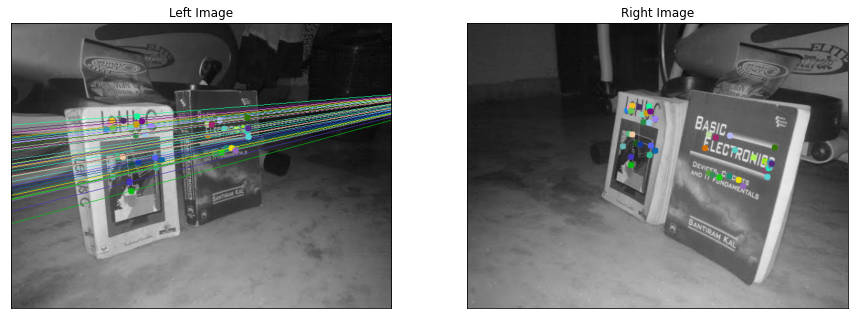

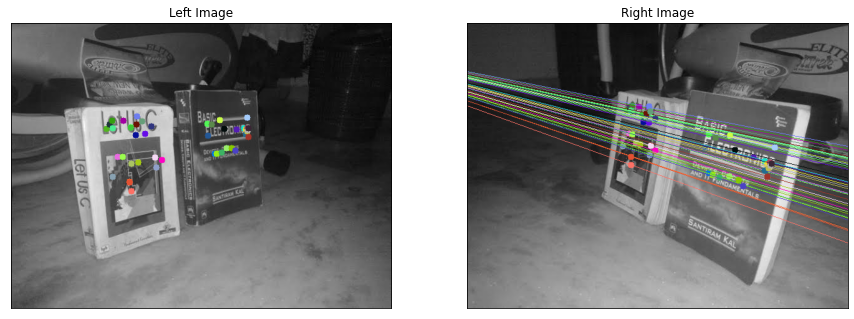

In [14]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgL = cv2.imread(path+"left.jpg", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(path+"right.jpg", cv2.IMREAD_GRAYSCALE)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2) # query image, train image

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) # least-median algorithm
# epipolar line in Right image = F ptsL (matrix multiplication)
# epipolar line in Left image = F' ptsR (matrix multiplication)


# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

### Disparity map from stereo images

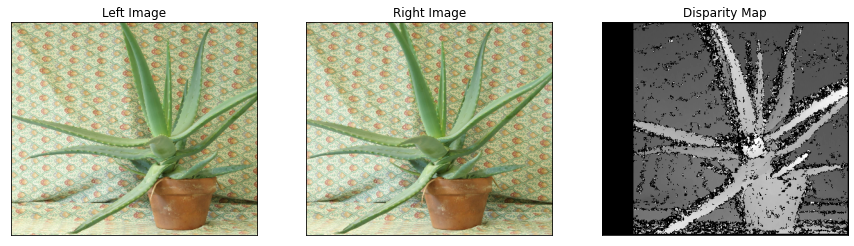

In [25]:
# load left and right images
imgL = cv2.imread(path+"aloeL.jpg");
imgR = cv2.imread(path+"aloeR.jpg");

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
# numDisparities is multiple of 16
# blocksize is always odd value within 5-255

stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=5) #stereo correspondence using the block matching algorithm
disparity = stereo.compute(imgL_gray, imgR_gray)

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(disparity, cmap="gray")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()